In [800]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.special import digamma, iv, jv, kv, sici
from scipy.integrate import quad, dblquad
import lhapdf
import pickle
import vegas
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
cr, cg, cb = plt.cm.Reds(.6), plt.cm.Greens(.6), plt.cm.Blues(.6)
cr2, cg2, cb2 = plt.cm.Reds(.8), plt.cm.Greens(.8), plt.cm.Blues(.8)
# QED:
alpha_em = 1/132 # at around bottom mass

# QCD
Lambda2 = 0.15**2
NC = 3.
CA = np.copy(NC)
CF = (NC**2-1)/(2.*NC)
TR = 1./2.
Nf = 3.
mN = 0.938
mpi = 0.136
beta0 = 11/3.*CA - 4./3.*TR*Nf
beta1 = 34/3.*CA**2 - 20/3.*CA*TR*Nf - 4*CF*TR*Nf
gamma0_cusp = 4
gamma1_cusp = (268/9.-4*np.pi**2/3.)*CA - 80/9.*TR*Nf
gamma0_V = -6*CF
bscale = 2*np.exp(-np.euler_gamma)
CF_gamma0_cusp_4pi = 1./4/np.pi * CF * gamma0_cusp
beta0_8pi = beta0/8/np.pi
two_CF_gamma0_cusp_8pi = 2*CF*gamma0_cusp/8/np.pi

# medium parameter
rhoG = 0.4/5.068**3
muD2 = 0.12
muD = np.sqrt(muD2)

# TMD NP parameters
muNP = 0.667
g1f = 0.106
g2 = 0.84
Qref = 1.5

def TMD_NP(b, Q):
    bstar = b/np.sqrt(1+muNP**2*b**2)
    return np.exp(-g2/2*np.log(b/bstar)*np.log(Q/Qref)/2-g1f*b**2/2)

"""
piPDF = lhapdf.mkPDF("JAM21PionPDFnlonll_double_Mellin/0").xfxQ2
pPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_p/0").xfxQ2
dPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A2_Z1").xfxQ2
BePDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A9_Z4").xfxQ2
FePDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A56_Z26").xfxQ2
WPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A184_Z74").xfxQ2
AuPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A197_Z79").xfxQ2

PDFalphas = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_p/0").alphasQ2
"""

'\npiPDF = lhapdf.mkPDF("JAM21PionPDFnlonll_double_Mellin/0").xfxQ2\npPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_p/0").xfxQ2\ndPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A2_Z1").xfxQ2\nBePDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A9_Z4").xfxQ2\nFePDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A56_Z26").xfxQ2\nWPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A184_Z74").xfxQ2\nAuPDF = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_A197_Z79").xfxQ2\n\nPDFalphas = lhapdf.mkPDF("nNNPDF30_nlo_as_0118_p/0").alphasQ2\n'

In [801]:
# Load all the PDFs

piPDF = lhapdf.mkPDF("JAM21PionPDFnlonll_double_Mellin/0").xfxQ2
pPDF = lhapdf.mkPDF("CT18NLO/0").xfxQ2
BePDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_Be9").xfxQ2
FePDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_Fe56").xfxQ2
WPDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_W184").xfxQ2
PtPDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_Pt195").xfxQ2
AuPDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_Au197").xfxQ2
PbPDF = lhapdf.mkPDF("EPPS21nlo_CT18Anlo_Pb208").xfxQ2

def Neutron(pid, x, Q2):
    if pid==1:
        return pPDF(2, x, Q2)
    elif pid==-1:
        return pPDF(-2, x, Q2)
    elif pid==2:
        return pPDF(1, x, Q2)
    elif pid==-2:
        return pPDF(-1, x, Q2)
    else:
        return pPDF(pid, x, Q2)
    
def pimPDF(pid, x, Q2):
    if pid!=21:
        return piPDF(-pid, x, Q2)
    else:
        return pPDF(21, x, Q2)
    
def dPDF(pid, x, Q2):
    return 0.5*( pPDF(pid, x, Q2) + Neutron(pid, x, Q2) )

PDFalphas = lhapdf.mkPDF("CT18NLO/0").alphasQ2

In [802]:
# Collinear energy loss, evolved to scale mu2
def B(w):
    si, ci = sici(w)
    return 4/np.pi*(w**2*si+np.sin(w)+w*np.cos(w)-2*w)/2/w**2

@np.vectorize
def CollEloss(E0, maxmu2, A):
    L = 1.2*5.068*(A**(1/3)-1.0) * np.sqrt(3/5)
    q2max = np.min([maxmu2, 5*E0/L])
    if q2max<muD2:
        return 0.
    dx = 4*CF*CA * np.pi * B(maxmu2*L/2/E0) \
         * rhoG*L**2/2/9/E0 * \
         ( PDFalphas(muD2) - PDFalphas(q2max) )
    return dx*0

In [803]:
# Load BFKL evolved collision factor (computed and interpolated from the other notebook)
with open("./BFKL_Evolved_Broadening_Factor.pkl",'rb') as f:
    CollBFKL = pickle.load(f)
    
def MediumColl(b, A, Ein, mode='el'):
    bstar = b/np.sqrt(1+muNP**2*b**2)
    L = 1.2*5.068*(A**(1/3)-1.0)*0.75
    if mode=='el':
        rap = 0
    else:
        rap = np.log(np.min([1+L/2/bstar, Ein*bstar]))
    return np.exp(rhoG*L * CollBFKL(rap, np.log(bstar))[0] )

In [804]:
# TMD calculation in the vacuum

@np.vectorize
def RapidityEvolutionFactor_A(xi0, xi1, mu, b):
    mub = bscale/b
    L1 = np.log(mu**2/Lambda2)
    L0 = np.log(mub**2/Lambda2)
    return np.exp( - 4*CF/beta0*np.log(L1/L0) * .5 * np.log(xi1/xi0) )

@np.vectorize
def RapidityEvolutionFactor_B(mu0, mu1, zeta, b):
    mub = bscale/b
    L1 = np.log(mu1**2/Lambda2)
    L0 = np.log(mu0**2/Lambda2)
    zeta0 = mu0**2
    return np.exp( - 4*CF/beta0*np.log(L1/L0) * .5 * np.log(zeta/zeta0) )

@np.vectorize
def ScaleEvolutionFactor(mu0, mu1, xi, b):
    mub = bscale/b
    L1 = np.log(mu1**2/Lambda2)
    L0 = np.log(mu0**2/Lambda2)
    S = np.log(L1/L0) * (3. - 2.*np.log(xi/Lambda2)) + 2*np.log(mu1**2/mu0**2)
    return np.exp(CF/beta0*S)


def CombinedEvolution(b, Q, choice=1):
    mu0 = bscale/b
    mu1 = Q
    zeta0 = mu0**2
    zeta1 = Q**2
    if choice==1:
        # choice 1:
        # Step 1, at mu=mu0, evolve dF/deta(mu=mu0, zeta) from zeta0 to zeta1
        F1 = RapidityEvolutionFactor_A(zeta0, zeta1, mu0, b)
        # Step 2, at fixed mu, evolve dF/dmu(mu, zeta) from zeta=mu^2 to zeta1
        # Step 3, at fixed zeta1, evolve B from mu0 to mu1
        F2 = ScaleEvolutionFactor(mu0, mu1, zeta1, b)
    else:
        # choice 2:
        # Step 1, at zeta=zeta0, evolve B(mu, zeta0) from mu0 to mu1 --> B(mu1, zeta0)
        F2 = ScaleEvolutionFactor(mu0, mu1, zeta0, b)
        # Step 2, at a fix zeta evolve dF/deta(mu, zeta)| = K(mu) from mu0 to mu --> K(mu1)
        # Step 2, at mu1, evolve B(mu1, zeta0) from zeta0 to zeta1 --> B(mu1, zeta1)
        F1 = RapidityEvolutionFactor_B(mu0, mu1, zeta1, b)
    return F1*F2

In [805]:
# TMDPDF: dN/d^2 k
@np.vectorize
def CNM_corrected_TMDPDF(A, PDF, pid, x, kT, Q, E0):
    Nz = 51
    z = np.exp(np.linspace(np.log(x),np.log(.99), Nz))
    dlnz = np.log(z[1]/z[0])
    
    # vacuum PDF at scale kT
    def df(lnb):
        
        b = np.exp(lnb)
        bstar = b/np.sqrt(1+muNP**2*b**2)
        mub = bscale/bstar
        zeta0 = mub**2
        abar = PDFalphas(mub**2)*CF/2/np.pi
        
        delta_z = CollEloss(z*E0, mub**2, A) if A>2 else 0
        xFxQ2 = np.array([ PDF(pid, ix, mub**2) if ix<0.999 else 0.
                           for ix in z*(1+delta_z) ]) \
              / (1+delta_z)**(1+CF/2/CA)
        
        Lb = np.log(mub**2*bstar**2/bscale**2)
        Matching = \
        xFxQ2[0]*( 1. + abar*(Lb*np.log(mub**2/zeta0) - Lb**2/2. - np.pi**2/12.) )   \
          + abar*(      ( xFxQ2[::-1] * z*(1.-z) ).sum() \
               - Lb * ( ( xFxQ2[::-1]*(1+z**2) - 2.*xFxQ2[0] ) * z/(1.-z) ).sum()
               ) * dlnz
        
        return Matching * CombinedEvolution(bstar, Q) \
             * jv(0, kT*b) \
             * TMD_NP(b, Q)\
             * ( MediumColl(b, A, x*E0, 'inel') if A>2 else 1) \
             * b**2
    
    return quad(df, np.log(.1/Q), np.log(10/np.sqrt(g1f)), epsrel=1e-2)[0]

In [806]:
# The TMDPDF after CNM
Q = 4.0
E = 400
kT = np.linspace(.1, 1.4, 11)

Xs = np.exp(np.linspace(np.log(.025),np.log(.7), 11))
R = np.zeros([kT.size, Xs.size])
for i, x in enumerate(Xs):
    Y0 = CNM_corrected_TMDPDF(1, pPDF, 2, x, kT, Q, E)
    Y1 = CNM_corrected_TMDPDF(197, pPDF, 2, x, kT, Q, E)
    R[:,i] = Y1/Y0

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


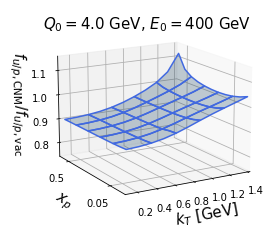

In [807]:
fig = plt.figure(figsize=(3.75, 4))
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(kT, Xs)
X = X.T
Y = Y.T

# Plot the 3D surface
#ax.plot_surface(X, np.log(Y), R1, edgecolor='red', lw=0.5, rstride=2, cstride=2,
#                alpha=0.3)
ax.plot_surface(X, np.log(Y), R, edgecolor='royalblue', lw=0.5, rstride=2, cstride=2,
                alpha=0.25, linewidth=1.5)
ax.set_yticks([np.log(0.05), np.log(0.5)])
ax.set_yticklabels(['0.05', '0.5'])
ax.set_zlim(0.75,1.15)
ax.set_xlim(0.1,1.4)
ax.set_ylim(np.log(0.025),np.log(.8))
ax.set_ylabel(r"$x_{p}$", fontsize=15)
ax.set_xlabel(r"$k_T$ [GeV]", fontsize=15)
ax.set_zlabel(r"$f_{u/p, \rm CNM}/f_{u/p, \rm vac}$", fontsize=15)
ax.annotate(r"$Q_0=4.0$ GeV, $E_0=400$ GeV", fontsize=15, xy=(.01,.9), xycoords="axes fraction")
ax.view_init(15, 240)
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=.0, left=0.16, right=.97)
plt.savefig("figs/Dynamical_broadening.png", dpi=300, transparent=True)

In [ ]:
# Inclusive DY, LO
@np.vectorize
def DY_dsigma_dxFdsstau(PDF1, PDF2, pid1, pid2, sqrts, sstau, xF, scale=1):
    Q = sqrts * sstau
    x1 = (np.sqrt(xF**2+4*sstau**2) +xF ) /2.
    x2 = (np.sqrt(xF**2+4*sstau**2) -xF ) /2.
    
    if (x1>1 or x2>1):
        return 0.
    
    Jacobian = sqrts**2 / np.sqrt(1+xF**2/4/sstau**2)
    
    ch= {1:1/3, 2:2/3, 3:1/3}[np.abs(pid1)]
    Prefactor = 4*np.pi/9*(1/137)**2/Q**4 * Q**2 * 20
    
    return Prefactor * ch**2 * PDF1(pid1, x1, scale*Q**2) * PDF2(pid2, x2, scale*Q**2) 


@np.vectorize
def DY_dsigma_dsstaudy(PDF1, PDF2, pid, sqrts, sstau, y, scale=1):
    Q = sstau*sqrts
    x1 = Q/sqrts*np.exp(y)
    x2 = Q/sqrts*np.exp(-y)
    
    if (x1>1 or x2>1):
        return 0.
    
    ch= {1:1/3, 2:2/3, 3:1/3}[np.abs(pid)]
    Prefactor = 4*np.pi/9*(1/137)**2/Q**4 
    Jacobian = 2*Q*sqrts
    return Prefactor * ch**2 * (
        PDF1(pid, x1, scale*Q**2) * PDF2(-pid, x2, scale*Q**2) 
      + PDF1(-pid, x1, scale*Q**2) * PDF2(pid, x2, scale*Q**2) 
    ) * Jacobian

In [318]:
# TMD for DY
def TMDPDF_in_A(A, PDF, ipid, z, dlnz, b, Q, E0, mode):
    bstar = b/np.sqrt(1+muNP**2*b**2)
    mub = bscale/bstar
    zeta0 = mub**2
    abar = PDFalphas(mub**2)*CF/2/np.pi

    delta_z = CollEloss(z*E0, mub**2, A) if A>2 else 0
    xFxQ2 = np.array([ PDF(ipid, ix, mub**2) if ix<0.99 else 0.
                       for ix in z*(1+delta_z) ]) \
          / (1+delta_z)**(1+CF/2/CA)

    Lb = np.log(mub**2*bstar**2/bscale**2)
    Matching = \
    xFxQ2[0]*( 1. + abar*(Lb*np.log(mub**2/zeta0) - Lb**2/2. - np.pi**2/12.) )   \
      + abar*(      ( xFxQ2[::-1] * z*(1.-z) ).sum() \
           - Lb * ( ( xFxQ2[::-1]*(1+z**2) - 2.*xFxQ2[0] ) * z/(1.-z) ).sum()
           ) * dlnz

    return Matching \
        * CombinedEvolution(bstar, Q) \
        * ( MediumColl(b, A, z[0]*E0, mode) if A>2 else 1)\
        * TMD_NP(b, Q)


@np.vectorize
def DY_dsigma_dQ2kTdkTdy(E1, E2, m1, m2, PDF1, PDF2,
                         pid, M, y, kT, 
                         A1, A2, mode='el'):
    ch= {1:1/3, 2:2/3, 3:1/3}[np.abs(pid)]
    P1 = np.sqrt(np.abs(E1**2-m1**2)); P2 = np.sqrt(np.abs(E2**2-m2**2))
    sqrts = np.sqrt(2*E1*E2 + 2*P1*P2 + m1**2 + m2**2)
    tau = (M**2+kT**2)/sqrts**2
    Q = np.sqrt(M**2+kT**2)
    x1 = np.sqrt(tau)*np.exp(y)
    x2 = np.sqrt(tau)*np.exp(-y)
    if (x1<0) or (x1>1) or (x2<0) or (x2>1):
        return 0
    
    Nz = 21
    z1 = np.exp(np.linspace(np.log(x1),np.log(.99), Nz)); dlnz1 = np.log(z1[1]/z1[0])
    z2 = np.exp(np.linspace(np.log(x2),np.log(.99), Nz)); dlnz2 = np.log(z2[1]/z2[0])    
    Prefactor = 4*np.pi*alpha_em**2/3./NC/Q**2/sqrts**2/x1/x2 * ch**2
    
    def df(lnb):
        b = np.exp(lnb)
        tmd1 = TMDPDF_in_A(A2, PDF1, pid, z1, dlnz1, b, Q, E1, mode)
        tmd2 = TMDPDF_in_A(A1, PDF2, -pid, z2, dlnz2, b, Q, E2, mode)
        return tmd1 * tmd2 * jv(0, kT*b) *  b**2
    
    return Prefactor * quad(df, np.log(0.1/Q), np.log(10/np.sqrt(g1f)), epsrel=.01)[0]



In [319]:
# Compare to ATLAS
pids = [1,2,3,-1,-2,-3]
conversion = 1/5.076**2 * 0.01 * 10**9
Rapbins = np.linspace(-2.86, 1.93, 9)
Raps = (Rapbins[1:]+Rapbins[:-1])/2.
pTatlas = np.array([0.25,0.5,1,2,3,5,7.5,10,12.5,15,17.5,20,25,30])
Ms = np.exp(np.linspace(np.log(15), np.log(60), 10))
Res = np.zeros_like(pTatlas)
for M1, M2 in zip(Ms[:-1], Ms[1:]):
    print(M1, M2)
    Mavg = (M1+M2)/2
    Res += np.average( [np.sum([DY_dsigma_dQ2kTdkTdy(8160**2/2/mN, mN, mN, mN, pPDF, pPDF,
                                   pid, Mavg, Rap, pTatlas, 
                                   1, 1) for pid in pids], axis=0)\
            * (M2**2-M1**2) / 2/np.pi * conversion
                      for Rap in Raps], axis=0
                     )

15.0 17.49793559364175
17.49793559364175 20.411850002615655
20.411850002615655 23.81101577952299
23.81101577952299 27.77624136861871
27.77624136861871 32.401792166769184
32.401792166769184 37.797631496846186
37.797631496846186 44.09203476826796
44.09203476826796 51.434638971184356
51.434638971184356 59.999999999999986


In [323]:
ResPb = np.zeros_like(pTatlas)
for M1, M2 in zip(Ms[:-1], Ms[1:]):
    print(M1, M2)
    Mavg = (M1+M2)/2
    ResPb += np.average( [np.sum([DY_dsigma_dQ2kTdkTdy(8160**2/2/mN, mN, mN, mN, pPDF, PbPDF,
                                   pid, Mavg, Rap, pTatlas, 
                                   1, 208, mode='inel') for pid in pids], axis=0)\
            * (M2**2-M1**2) / 2/np.pi * conversion
                      for Rap in Raps], axis=0
                     )

15.0 17.49793559364175
17.49793559364175 20.411850002615655
20.411850002615655 23.81101577952299
23.81101577952299 27.77624136861871
27.77624136861871 32.401792166769184
32.401792166769184 37.797631496846186
37.797631496846186 44.09203476826796
44.09203476826796 51.434638971184356
51.434638971184356 59.999999999999986


/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/home/weiyao/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


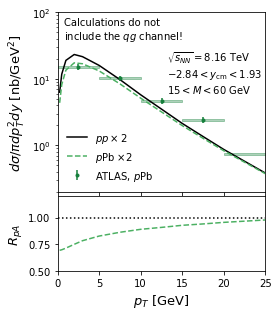

In [390]:
def plotATLAS(ax):
    pT, pTl, pTh, dsigma, stat, _, sys, _ = np.loadtxt("./Expdata/ATLAS-RpPb-8160GeV.dat").T
    ax.errorbar(pT, dsigma, yerr=stat, fmt='.', color=cg2, label='ATLAS, $p$Pb')
    for xl, xh, yl, yh in zip(pTl, pTh, dsigma-sys, dsigma+sys):
        ax.fill_between([xl, xh], [yl]*2, [yh]*2, color=cg2, alpha=.35)

fig = plt.figure(figsize=(3.75, 4.2), tight_layout=True)
gs = gridspec.GridSpec(10, 1)
ax = fig.add_subplot(gs[:7, 0])
ax2 = fig.add_subplot(gs[7:, 0])

plotATLAS(ax)
ax.plot(pTatlas, Res*pTatlas*np.pi*2*(1.93+2.84)*208*2, 'k-', label=r'$pp\times 2$')
ax.plot(pTatlas, ResPb*pTatlas*np.pi*2*(1.93+2.84)*208*2, '--', color=cg, label=r'$p$Pb $\times 2$')

ax.set_xlabel(r"$p_T$ [GeV]", fontsize=13)
ax.set_ylabel(r"$d\sigma/\pi dp_T^2 dy$ [nb/GeV${}^2$]", fontsize=13)
ax.legend(loc='lower left', framealpha=0)
ax.semilogy()
#ax.semilogx()
ax.set_ylim(2e-1, 1e2)
ax.set_xlim(0,25)
ax.annotate("$\sqrt{s_{NN}}=8.16$ TeV\n$-2.84<y_{{\mathrm{cm}}}<1.93$\n$15<M<60$ GeV", 
            xy=(.525, .55), xycoords="axes fraction")
ax.annotate("Calculations do not \ninclude the $qg$ channel!", xy=(.03,.85), xycoords='axes fraction')

ax2.plot([0,30],[1,1],'k:')
ax2.plot(pTatlas, ResPb/Res, '--', color=cg)

ax2.set_ylim(0.5,1.2)
ax2.set_xlim(0,25)
ax.set_xticklabels([])
ax2.set_ylabel(r"$R_{pA}$", fontsize=13)
ax2.set_xlabel(r"$p_T$ [GeV]", fontsize=13)
#plt.tight_layout()

plt.subplots_adjust(left=.2, right=.97, top=.98)
plt.savefig("figs/DY-pPb-ATLAS.png", dpi=300)

In [183]:
# Compare to PHENIX
pids = [1,2,3,-1,-2,-3]
conversion = 1/5.076**2 * 0.01 * 10**9
Rapbins = np.linspace(1.2, 2.2, 5)
Raps = (Rapbins[1:]+Rapbins[:-1])/2.
pT = np.array([0.25, 0.75, 1.25, 1.75, 2.25,
                 2.75, 3.25, 3.75, 4.25, 4.75,
                 5.25, 5.75])
Ms = np.linspace(4.8, 8.4, 6)
Res = np.zeros_like(pT)
for M1, M2 in zip(Ms[:-1], Ms[1:]):
    print(M1, M2)
    Mavg = (M1+M2)/2
    Res += np.average( [np.sum([DY_dsigma_dQ2kTdkTdy(100, 100, mN, mN, pPDF, pPDF,
                                   pid, Mavg, Rap, pT, 
                                   1, 1) for pid in pids], axis=0)\
            * (M2**2-M1**2) / 2/np.pi * conversion
                      for Rap in Raps], axis=0
                     )

4.8 5.52
5.52 6.24
6.24 6.96
6.96 7.68
7.68 8.4


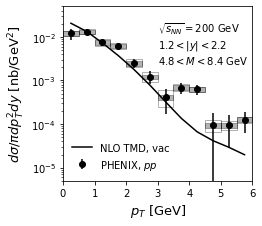

In [278]:
def plotPHENIX(ax):
    pT, dsigma, stat, sys1p, sys1m, sys2 = np.loadtxt("./Expdata/PHENIX-pp-DY-200GeV.dat").T
    dsigma /= 1e3
    stat  /= 1e3
    sys1p  /= 1e3
    sys1m  /= 1e3 
    sys2 /= 1e3
    ax.errorbar(pT, dsigma, yerr=stat, fmt='ko', label='PHENIX, $pp$')
    pTl = pT-0.25
    pTh = pT+0.25
    for xl, xh, yl, yh in zip(pTl, pTh, dsigma-sys2, dsigma+sys2):
        ax.fill_between([xl, xh], [yl]*2, [yh]*2, color='k', alpha=.3)
    for xl, xh, yl, yh in zip(pTl, pTh, dsigma+sys1p, dsigma+sys1m):
        ax.fill_between([xl, xh], [yl]*2, [yh]*2, facecolor='none', edgecolor='k', alpha=.3)
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.75, 3.25), sharex=True, sharey=True)
plotPHENIX(ax)
ax.plot(pT, Res, 'k-', label='NLO TMD, vac')
ax.semilogy()

ax.set_xlabel(r"$p_T$ [GeV]", fontsize=13)
ax.set_ylabel(r"$d\sigma/\pi dp_T^2 dy$ [nb/GeV${}^2$]", fontsize=13)
ax.legend(loc='lower left', framealpha=0)
ax.semilogy()
ax.set_ylim(5e-6,5e-2)
ax.set_xlim(0,6)
ax.annotate("$\sqrt{s_{NN}}=200$ GeV\n$1.2<|y|<2.2$\n$4.8<M<8.4$ GeV", xy=(.5, .67), xycoords="axes fraction")

plt.tight_layout()

plt.savefig("figs/DY-pp-PHENIX.png", dpi=300)

In [244]:
# Project PHENIX
pids = [1,2,3,-1,-2,-3]
conversion = 1/5.076**2 * 0.01 * 10**9
Rapbins = np.linspace(1.2, 2.2, 5)
Raps = (Rapbins[1:]+Rapbins[:-1])/2.
pT = np.array([0.25, 0.75, 1.25, 1.75, 2.25,
                 2.75, 3.25, 3.75, 4.25, 4.75,
                 5.25, 5.75])
Ms = np.linspace(4.8, 8.4, 6)
ResRad = np.zeros_like(pT)
for M1, M2 in zip(Ms[:-1], Ms[1:]):
    print(M1, M2)
    Mavg = (M1+M2)/2
    ResRad += np.average( [np.sum([DY_dsigma_dQ2kTdkTdy(200**2/2/mN, mN, mN, mN, pPDF, AuPDF,
                                   pid, Mavg, Rap, pT, 
                                   1, 197, mode='inel') for pid in pids], axis=0)\
            * (M2**2-M1**2) / 2/np.pi * conversion
                      for Rap in Raps], axis=0
                     )

4.8 5.52
5.52 6.24
6.24 6.96
6.96 7.68
7.68 8.4


In [245]:
ResRad_Augo = np.zeros_like(pT)
for M1, M2 in zip(Ms[:-1], Ms[1:]):
    print(M1, M2)
    Mavg = (M1+M2)/2
    ResRad_Augo += np.average( [np.sum([DY_dsigma_dQ2kTdkTdy(200**2/2/mN, mN, mN, mN, pPDF, AuPDF,
                                   pid, Mavg, -Rap, pT, 
                                   1, 197, mode='inel') for pid in pids], axis=0)\
            * (M2**2-M1**2) / 2/np.pi * conversion
                      for Rap in Raps], axis=0
                     )

4.8 5.52
5.52 6.24
6.24 6.96
6.96 7.68
7.68 8.4


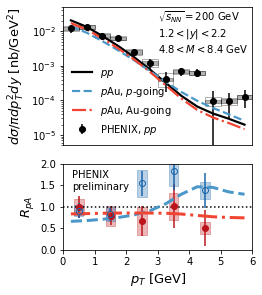

In [284]:
fig = plt.figure(figsize=(3.75, 4.2), tight_layout=True)
gs = gridspec.GridSpec(10, 1)
ax1 = fig.add_subplot(gs[:6, 0])
ax2 = fig.add_subplot(gs[6:, 0])

def plotPHENIX_RpA_A(ax):
    pT, y, stat, sys = np.loadtxt("./Expdata/PHENIX-RpA-Au-going-DY-200GeV.dat").T
    ax.errorbar(pT, y, yerr=stat, fmt='o', color=cr2, label='PHENIX, $pp$')
    pTl = pT-0.15
    pTh = pT+0.15
    for xl, xh, yl, yh in zip(pTl, pTh, y-sys, y+sys):
        ax.fill_between([xl, xh], [yl]*2, [yh]*2, color=cr2, alpha=.3)
        
def plotPHENIX_RpA_p(ax):
    pT, y, stat, sys = np.loadtxt("./Expdata/PHENIX-RpA-p-going-DY-200GeV.dat").T
    ax.errorbar(pT, y, yerr=stat, fmt='o', mfc='none', color=cb2, label='PHENIX, $pp$')
    pTl = pT-0.15
    pTh = pT+0.15
    for xl, xh, yl, yh in zip(pTl, pTh, y-sys, y+sys):
        ax.fill_between([xl, xh], [yl]*2, [yh]*2, color=cb2, alpha=.3)

plotPHENIX(ax1)
ax1.plot(pT, Res, 'k-', label='$pp$', lw=2.2)
ax1.plot(pT, ResRad, '--', color=cb, label=r'$p$Au, $p$-going', lw=2.2)
ax1.plot(pT, ResRad_Augo, '-.', color=cr, label=r'$p$Au, Au-going', lw=2.2)
ax1.semilogy()
ax1.set_xlim(0,6)
ax1.set_ylim(5e-6,5e-2)
ax1.set_ylabel(r"$d\sigma/\pi dp_T^2 dy$ [nb/GeV${}^2$]", fontsize=13)
ax1.legend(loc='lower left', framealpha=0)
ax1.set_xticks([])

plotPHENIX_RpA_A(ax2)
plotPHENIX_RpA_p(ax2)
ax2.plot([0,6], [1,1], 'k:')
ax2.set_xlabel(r"$p_T$ [GeV]", fontsize=13)
ax2.set_xlim(0,6)
ax2.set_ylim(0.,2)
#ax2.set_yticks([.8, 1., 1.2])
ax2.set_ylabel(r"$R_{pA}$", fontsize=13)
ax2.plot(pT, ResRad/Res, '--', color=cb, lw=3)
ax2.plot(pT, ResRad_Augo/Res, '-.', color=cr, lw=3)
ax2.annotate("PHENIX\npreliminary", xy=(.05,.7), xycoords="axes fraction")
ax1.annotate("$\sqrt{s_{NN}}=200$ GeV\n$1.2<|y|<2.2$\n$4.8<M<8.4$ GeV", xy=(.5, .67), xycoords="axes fraction")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("figs/DY-pp-pA-PHENIX.png", dpi=300)

5 6
6 7
7 8
11 12
12 13
13 14


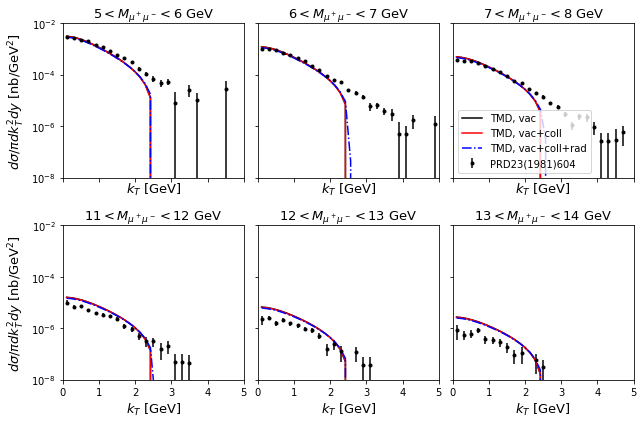

In [105]:
# Compare to vac data
pids = [1,2,3,-1,-2,-3]
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(3*3, 2*3), sharex=True, sharey=True)
axes = axes.flatten()
Rap = 0.0
conversion = 1/5.076**2 * 0.01 * 10**9
X = []
Yvac = []
Ycoll = []
Yrad = []
for (M1, M2), ax in zip([(5,6),(6,7),(7,8),(11,12),(12,13),(13,14)], axes):
    print(M1, M2)
    Mavg = (M1+M2)/2.
    x, xl, xh, y, yerr = np.loadtxt("./Expdata/DY-kT-sqrts400-Q-{}-{}.dat".format(M1, M2), usecols=[0,1,2,3,4]).T
    E = 1/10**6
    y *= E
    yerr *= E
    
    kTs = np.linspace(0.1, 3.0, 21)
    
    Y0 = np.sum([DY_dsigma_dQ2kTdkTdy(400, mN, mN, mN, pPDF, pPDF,
                                      pid, Mavg, Rap, kTs, 
                                      1, 1) for pid in pids], axis=0)\
        * (M2**2-M1**2) / 2/np.pi * conversion
    Y1 = np.sum([DY_dsigma_dQ2kTdkTdy(400, mN, mN, mN, pPDF, pPDF,
                                      pid, Mavg, Rap, kTs, 
                                      1, 195, mode='el') for pid in pids], axis=0)\
        * (M2**2-M1**2) / 2/np.pi * conversion
    Y2 = np.sum([DY_dsigma_dQ2kTdkTdy(400, mN, mN, mN, pPDF, pPDF,
                                      pid, Mavg, Rap, kTs, 
                                      1, 195, mode='rad') for pid in pids], axis=0)\
        * (M2**2-M1**2) / 2/np.pi * conversion
    X.append(kTs)
    Yvac.append(Y0)
    Ycoll.append(Y1)
    Yrad.append(Y2)
    ax.plot(kTs, Y0, 'k-', label=r'TMD, vac')
    ax.plot(kTs, Y1, 'r-', label=r'TMD, vac+coll')
    ax.plot(kTs, Y2, 'b-.', label=r'TMD, vac+coll+rad')
    ax.errorbar(x, y, yerr=yerr, fmt='k.', label='PRD23(1981)604' )
    
    ax.set_title(r"${}<M_{{\mu^+\mu^-}}<{}$ GeV".format(M1, M2), fontsize=13)
    ax.set_xlabel(r"$k_T$ [GeV]", fontsize=13)
    ax.semilogy()
for ax in axes:
    if ax.is_first_col():
        ax.set_ylabel(r"$d\sigma/\pi dk_T^2 dy$ [nb/GeV${}^2$]", fontsize=13)
axes[2].legend()
#ax.semilogy()
ax.set_ylim(1e-8,1e-2)
ax.set_xlim(0,5)
plt.tight_layout()
plt.savefig("figs/DY-pPt-vacuum-calulation.png", dpi=300)

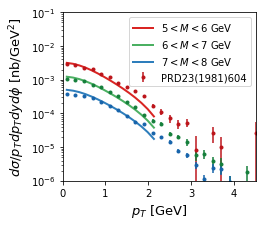

In [180]:
# make plots
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.75, 3.25), sharex=True, sharey=True)
conversion = 1/5.076**2 * 0.01 * 10**9
for (M1, M2), yvac, color, color2 in zip([(5,6),(6,7),(7,8)], Yvac, [cr, cg, cb], [cr2, cg2, cb2]):
    x, xl, xh, y, yerr = np.loadtxt("./Expdata/DY-kT-sqrts400-Q-{}-{}.dat".format(M1, M2), usecols=[0,1,2,3,4]).T
    E = 1/10**6
    y *= E
    yerr *= E
    
    cut = (kTs<2.25)
    ax.plot(kTs[cut], yvac[cut], '-', lw=2, color=color, label=r"${}<M<{}$ GeV".format(M1, M2))
    ax.errorbar(x, y, yerr=yerr, fmt='.', color=color2, label='PRD23(1981)604'if M1==5 else '' )
    
ax.set_xlabel(r"$p_T$ [GeV]", fontsize=13)
ax.set_ylabel(r"$d\sigma/p_T dp_T dy d\phi $ [nb/GeV${}^2$]", fontsize=13)
ax.legend(loc='upper right')
ax.semilogy()
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(0,4.5)
            
plt.tight_layout()
plt.savefig("figs/DY-pPt-vacuum-calulation.png", dpi=300)

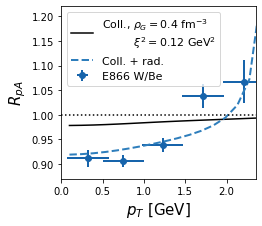

In [799]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.75, 3.25), sharex=True, sharey=True)

cr, cb = plt.cm.Reds(.7), plt.cm.Blues(.7)

ax.plot(X[2], Ycoll[2]/Yvac[2], 'k-', label=r"Coll., $\rho_G=0.4$ fm${}^{-3}$"+'\n'+r"         $\xi^2=0.12$ GeV${}^2$")
ax.plot(X[2], Yrad[2]/Yvac[2], '--', color=cb, lw=2, label='Coll. + rad.')


pT, pTl, pTh, y, stat, _ = np.loadtxt("./Expdata/NuSea-W-Be.dat").T
ax.errorbar(pT, y, yerr=stat, xerr=(pTh-pTl)/2, fmt='o', color=cb2, lw=2, alpha=1, label='E866 W/Be')

ax.legend(fontsize=11)
ax.plot([0,3],[1,1], 'k:')

ax.set_xlim(0,2.35)
ax.set_ylim(0.87, 1.22)
plt.xlabel(r"$p_T$ [GeV]", fontsize=15)
plt.ylabel(r"$R_{pA}$", fontsize=15)
plt.tight_layout()
plt.savefig("Coll-Rad.png", dpi=300)

In [83]:
def DY_dsigma_kTdkT(
        E1, E2, m1, m2, PDF1, PDF2,
        kT, 
        A1, A2, mode,
        x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh):
    P1 = np.sqrt(np.abs(E1**2-m1**2)); P2 = np.sqrt(np.abs(E2**2-m2**2))
    sqrts = np.sqrt(2*E1*E2 + 2*P1*P2 + m1**2 + m2**2)
    Nz = 51
    Qmax = np.sqrt(M2h)
    pids = [ 1,2,3,-1,-2,-3]
    integ = vegas.Integrator([[x1l,       x1h], 
                              [x2l,       x2h], 
                              [np.log(0.1/Qmax), np.log(10/np.sqrt(g1f))]
                             ])

    Prefactor = 4*np.pi*alpha_em**2*2/3./NC
    def df(XS):
        x1, x2, lnb = XS
        tau = x1*x2
        M2 = sqrts**2*tau
        if  M2<M2l or M2>M2h:
            return 0
        xF = x1-x2
        if  xF<xFl or xF>xFh:
            return 0
        
        Q = M2**0.5
        b = np.exp(lnb)
        z1 = np.exp(np.linspace(np.log(x1),np.log(.9999), Nz))
        dlnz1 = np.log(z1[1]/z1[0])
        z2 = np.exp(np.linspace(np.log(x2),np.log(.9999), Nz))
        dlnz2 = np.log(z2[1]/z2[0])    
        
        res = 0.0
        for pid in pids:
            ch= {1:1/3, 2:2/3, 3:1/3}[np.abs(pid)]
            tmd1 = TMDPDF_in_A(A2, PDF1, pid, z1, dlnz1, b, Q, E1, mode)
            tmd2 = TMDPDF_in_A(A1, PDF2, -pid, z2, dlnz2, b, Q, E2, mode)
            res += ch**2 * tmd1 * tmd2
        return res * jv(0, kT*b) * b**2
    
    result = integ(df, nitn=20, neval=4000)
    print(kT, 'result = %s    Q = %.2f' % (result, result.Q))
    return result.val * Prefactor, result.sdev * Prefactor

In [84]:
# E886
Eproton = 800
mN = 0.938
sqrts = np.sqrt(2*Eproton*mN+2*mN**2)
kT = np.linspace(.15, 2.5, 11)
x1l, x1h = 0.21, 0.95
x2l, x2h = 0.01, 0.12
M2l, M2h = 4**2, 8.4**2
xFl, xFh = 0.13, 0.93
Fe = np.array([DY_dsigma_kTdkT(
                            Eproton, mN, mN, mN, pPDF, FePDF,
                            ikT, 
                            1, 56, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])

0.15 result = 0.0017003(29)    Q = 0.05
0.385 result = 0.0014903(25)    Q = 0.43
0.62 result = 0.0011884(23)    Q = 0.22
0.8550000000000001 result = 0.0008879(20)    Q = 0.05
1.09 result = 0.0006428(19)    Q = 0.62
1.325 result = 0.0004544(17)    Q = 0.73
1.56 result = 0.0003101(14)    Q = 0.80
1.795 result = 0.0002030(14)    Q = 0.17
2.0300000000000002 result = 0.0001239(14)    Q = 0.72
2.265 result = 0.0000643(13)    Q = 1.00
2.5 result = 0.0000217(14)    Q = 0.16


In [85]:
Be = np.array([DY_dsigma_kTdkT(
                            Eproton, mN, mN, mN, pPDF, BePDF,
                            ikT, 
                            1, 9, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])

0.15 result = 0.0018034(31)    Q = 0.68
0.385 result = 0.0015748(27)    Q = 0.35
0.62 result = 0.0012569(23)    Q = 0.53
0.8550000000000001 result = 0.0009356(20)    Q = 0.34
1.09 result = 0.0006704(20)    Q = 0.78
1.325 result = 0.0004709(18)    Q = 0.80
1.56 result = 0.0003183(16)    Q = 0.62
1.795 result = 0.0002084(15)    Q = 0.19
2.0300000000000002 result = 0.0001239(15)    Q = 0.36
2.265 result = 0.0000590(14)    Q = 0.59
2.5 result = 0.0000173(15)    Q = 0.95


In [86]:
W = np.array([DY_dsigma_kTdkT(
                            Eproton, mN, mN, mN, pPDF, WPDF,
                            ikT, 
                            1, 184, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])

0.15 result = 0.0015933(27)    Q = 0.39
0.385 result = 0.0013999(23)    Q = 0.49
0.62 result = 0.0011179(21)    Q = 0.44
0.8550000000000001 result = 0.0008404(19)    Q = 0.30
1.09 result = 0.0006126(17)    Q = 0.52
1.325 result = 0.0004338(15)    Q = 0.17
1.56 result = 0.0003021(15)    Q = 0.96
1.795 result = 0.0002007(13)    Q = 0.46
2.0300000000000002 result = 0.0001214(13)    Q = 0.10
2.265 result = 0.0000663(13)    Q = 0.22
2.5 result = 0.0000270(13)    Q = 0.54


/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


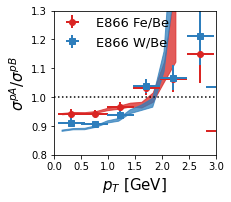

In [408]:
# plot E866
fig, ax = plt.subplots(1,1, figsize=(3.,2.6))
cb, cr = plt.cm.Blues(.7), plt.cm.Reds(.7)

RA = Fe[:,0]/Be[:,0]
dRA = RA*np.sqrt((Fe[:,1]/Fe[:,0])**2+(Be[:,1]/Be[:,0])**2)
ax.fill_between(kT, RA-dRA, RA+dRA, color=cr, alpha=0.75)

RA = W[:,0]/Be[:,0]
dRA = RA*np.sqrt((W[:,1]/W[:,0])**2+(Be[:,1]/Be[:,0])**2)
ax.fill_between(kT, RA-dRA, RA+dRA, color=cb, alpha=0.75)

pT, pTl, pTh, y, stat, _ = np.loadtxt("./Expdata/NuSea-Fe-Be.dat").T
ax.errorbar(pT, y, yerr=stat, xerr=(pTh-pTl)/2,fmt='o', color=cr, lw=2, alpha=1, label='E866 Fe/Be')
 
pT, pTl, pTh, y, stat, _ = np.loadtxt("./Expdata/NuSea-W-Be.dat").T
ax.errorbar(pT, y, yerr=stat, xerr=(pTh-pTl)/2,fmt='s', color=cb, lw=2, alpha=1, label='E866 W/Be')


ax.legend(loc=(.0,.7), fontsize=13, framealpha=0)
ax.set_ylabel(r"$\sigma^{pA}/\sigma^{ pB}$", fontsize=15)
ax.set_xlabel(r"$p_T$ [GeV]", fontsize=15)

ax.set_xticks([0,.5,1,1.5,2,2.5,3,3.5])
ax.set_xlim(0,3.)
ax.set_ylim(0.8, 1.3)
ax.plot([0,3],[1,1],'k:')
plt.tight_layout(True)
plt.subplots_adjust(left=.21, right=0.96, top=.97, bottom=.2)

plt.savefig("Compare_to_E886.png", dpi=300)

In [89]:
# E772
Eproton = 800
kT = np.linspace(.15, 2.25, 11)
x1l, x1h = 0.01, 0.9
x2l, x2h = 0.01, 0.9
M2l, M2h = 4.5**2, 9**2
xFl, xFh = -0.1,0.75


D772 = np.array([DY_dsigma_kTdkT(
                            Eproton, mN, mN, mN, pPDF, dPDF,
                            ikT, 
                            1, 2, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])

Fe772 = np.array([DY_dsigma_kTdkT(
                            Eproton, mN, mN, mN, pPDF, FePDF,
                            ikT, 
                            1, 56, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])


0.15 result = 0.003521(11)    Q = 0.02
0.36 result = 0.0031472(95)    Q = 0.57
0.5700000000000001 result = 0.002631(10)    Q = 0.45
0.7800000000000001 result = 0.0020345(75)    Q = 0.10
0.9900000000000001 result = 0.0015339(57)    Q = 0.20
1.2 result = 0.0011442(63)    Q = 0.70
1.4100000000000001 result = 0.0008244(61)    Q = 0.77
1.62 result = 0.0005691(49)    Q = 0.68
1.83 result = 0.0003873(47)    Q = 0.21
2.04 result = 0.0002363(46)    Q = 0.39
2.25 result = 0.0001220(47)    Q = 0.41
0.15 result = 0.0032355(91)    Q = 0.09
0.36 result = 0.0029052(88)    Q = 0.45
0.5700000000000001 result = 0.0024167(94)    Q = 0.46
0.7800000000000001 result = 0.0018938(73)    Q = 0.01
0.9900000000000001 result = 0.0014391(57)    Q = 0.62
1.2 result = 0.0010582(49)    Q = 0.09
1.4100000000000001 result = 0.0007798(60)    Q = 0.98
1.62 result = 0.0005492(39)    Q = 0.52
1.83 result = 0.0003735(39)    Q = 0.59
2.04 result = 0.0002410(47)    Q = 0.97
2.25 result = 0.0001313(40)    Q = 0.03


/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


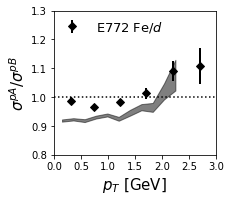

In [409]:
#E772
fig, ax = plt.subplots(1,1, figsize=(3.,2.6))
cb, cr = plt.cm.Blues(.7), plt.cm.Reds(.7)


RA = Fe772[:,0]/D772[:,0]
dRA = RA*np.sqrt((Fe772[:,1]/Fe772[:,0])**2+(D772[:,1]/D772[:,0])**2)
ax.fill_between(kT, RA-dRA, RA+dRA, color='k', alpha=0.5)
 
pT, y, stat, _ = np.loadtxt("./Expdata/E772.dat").T
ax.errorbar(pT, y, yerr=stat, fmt='D', color='k', lw=2, alpha=1, label='E772 Fe/$d$')

ax.legend(loc=(.0,.8), fontsize=13, framealpha=0)
ax.set_ylabel(r"$\sigma^{pA}/\sigma^{ pB}$", fontsize=15)
ax.set_xlabel(r"$p_T$ [GeV]", fontsize=15)

ax.set_xticks([0,.5,1,1.5,2,2.5,3,3.5])
ax.set_xlim(0,3.)
ax.plot([0,3],[1,1],'k:')
ax.set_ylim(0.8, 1.3)
plt.tight_layout(True)
plt.subplots_adjust(left=.21, right=0.96, top=.97, bottom=.2)

plt.savefig("Compare_to_E772.png", dpi=300)

In [91]:
# Compare to NA10
kT = np.linspace(.15, 2.25, 11)
x1l, x1h = 0.2, 0.8
x2l, x2h = 0.1, 0.5
M2l, M2h = 4.4**2, 8.5**2
xFl, xFh = 0, 0.6

#"""
Epi1 = 140
W_NA10_1 = np.array([DY_dsigma_kTdkT(
                            Epi1, mN, mpi, mN, pimPDF, WPDF,
                            ikT, 
                            1, 184, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])
D_NA10_1 = np.array([DY_dsigma_kTdkT(
                            Epi1, mN, mpi, mN, pimPDF, dPDF,
                            ikT, 
                            1, 2, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])
#"""

Epi2 = 286
W_NA10_2 = np.array([DY_dsigma_kTdkT(
                            Epi2, mN, mpi, mN, pimPDF, WPDF,
                            ikT, 
                            1, 184, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])
D_NA10_2 = np.array([DY_dsigma_kTdkT(
                            Epi2, mN, mpi, mN, pimPDF, dPDF,
                            ikT, 
                            1, 2, 'inel',
                            x1l, x1h, x2l, x2h, M2l, M2h, xFl, xFh) for ikT in kT])

0.15 result = 0.0044945(97)    Q = 0.29
0.36 result = 0.0039461(91)    Q = 0.31
0.5700000000000001 result = 0.0031248(73)    Q = 0.15
0.7800000000000001 result = 0.0023331(66)    Q = 0.45
0.9900000000000001 result = 0.0016360(59)    Q = 0.46
1.2 result = 0.0011098(56)    Q = 0.15
1.4100000000000001 result = 0.0007105(41)    Q = 0.09
1.62 result = 0.0004255(43)    Q = 0.52
1.83 result = 0.0002211(43)    Q = 0.33
2.04 result = 0.0000844(42)    Q = 0.38
2.25 result = -0.0000227(41)    Q = 0.68
0.15 result = 0.004765(12)    Q = 0.90
0.36 result = 0.0041627(90)    Q = 0.45
0.5700000000000001 result = 0.0032917(75)    Q = 0.20
0.7800000000000001 result = 0.0024130(69)    Q = 0.88
0.9900000000000001 result = 0.0016844(64)    Q = 0.27
1.2 result = 0.0011203(52)    Q = 0.39
1.4100000000000001 result = 0.0007111(47)    Q = 0.64
1.62 result = 0.0004308(47)    Q = 0.66
1.83 result = 0.0002230(44)    Q = 0.19
2.04 result = 0.0000668(45)    Q = 0.01
2.25 result = -0.0000373(45)    Q = 0.81
0.15 resu

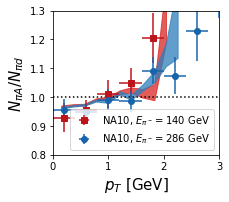

In [406]:
#NA10
fig, ax = plt.subplots(1,1, figsize=(3,2.6))
cb, cr = plt.cm.Blues(.7), plt.cm.Reds(.7)

Norm = (W_NA10_1[:,0]*kT).sum() / (D_NA10_1[:,0]*kT).sum()
RA = W_NA10_1[:,0]/D_NA10_1[:,0] / Norm
cut = (RA>.8)
dRA = RA*np.sqrt((W_NA10_1[:,1]/W_NA10_1[:,0])**2+(D_NA10_1[:,1]/D_NA10_1[:,0])**2)
ax.fill_between(kT[cut], (RA-dRA)[cut], (RA+dRA)[cut], color=cr, alpha=0.75)
 
Norm = (W_NA10_2[:,0]*kT).sum() / (D_NA10_2[:,0]*kT).sum()
RA = W_NA10_2[:,0]/D_NA10_2[:,0] / Norm
dRA = RA*np.sqrt((W_NA10_2[:,1]/W_NA10_2[:,0])**2+(D_NA10_2[:,1]/D_NA10_2[:,0])**2)
ax.fill_between(kT, RA-dRA, RA+dRA, color=cb, alpha=0.75)
 
x,xl,xh,y,ystat=np.loadtxt("./Expdata/NA10-140-DY.dat").T
ax.errorbar(x,y,xerr=(xh-xl)/2, yerr=ystat, fmt='s', color=cr2, alpha=1, label=r"NA10, $E_{\pi^-}=140$ GeV")
x,xl,xh,y,ystat=np.loadtxt("./Expdata/NA10-286-DY.dat").T
ax.errorbar(x,y,xerr=(xh-xl)/2, yerr=ystat, fmt='o', color=cb2, alpha=1, label=r"NA10, $E_{\pi^-}=286$ GeV")
ax.set_xlabel(r"$p_T$ [GeV]", fontsize=15)
ax.set_ylabel(r"$N_{\pi A}/N_{\pi d}$", fontsize=15)
ax.legend(loc='lower right')
ax.set_xlim(0,3)
ax.set_ylim(0.8,1.3)
ax.plot([0,3],[1,1],'k:')
plt.tight_layout()
plt.subplots_adjust(left=.21, right=0.98, top=.97, bottom=.2)
plt.savefig("Compare_to_NA10.png",dpi=300)

In [ ]:
# parton production

# TMD for DY
def TMDPDF_in_A(A, PDF, ipid, z, dlnz, b, Q, E0, mode):
    bstar = b/np.sqrt(1+muNP**2*b**2)
    mub = bscale/bstar
    zeta0 = mub**2
    abar = PDFalphas(mub**2)*CF/2/np.pi

    delta_z = 0# CollEloss(z*E0, mub**2, A) if A>2 else 0
    xFxQ2 = np.array([ PDF(ipid, ix, mub**2) if ix<0.99 else 0.
                       for ix in z*(1+delta_z) ]) \
          / (1+delta_z)**(1+CF/2/CA)

    Lb = np.log(mub**2*bstar**2/bscale**2)
    Matching = \
    xFxQ2[0]*( 1. + abar*(Lb*np.log(mub**2/zeta0) - Lb**2/2. - np.pi**2/12.) )   \
      + abar*(      ( xFxQ2[::-1] * z*(1.-z) ).sum() \
           - Lb * ( ( xFxQ2[::-1]*(1+z**2) - 2.*xFxQ2[0] ) * z/(1.-z) ).sum()
           ) * dlnz

    return Matching \
        * CombinedEvolution(bstar, Q) \
        * np.exp(-b**2*A**(1/3)*0.12/4)\
        * TMD_NP(b, Q)


@np.vectorize
def Hadron(E1, E2, m1, m2, PDF1, PDF2,
            pid, y, kT, 
            A1, A2, mode='el'):
    ch= {1:1/3, 2:2/3, 3:1/3}[np.abs(pid)]
    P1 = np.sqrt(np.abs(E1**2-m1**2)); P2 = np.sqrt(np.abs(E2**2-m2**2))
    sqrts = np.sqrt(2*E1*E2 + 2*P1*P2 + m1**2 + m2**2)
    Q = 1.0*kT
    x1 = kT*np.exp(y)/sqrts
    x2 = kT*np.exp(-y)/sqrts
    if (x1<0) or (x1>1) or (x2<0) or (x2>1):
        return 0
    
    Nz = 51
    z1 = np.exp(np.linspace(np.log(x1),np.log(.99), Nz)); dlnz1 = np.log(z1[1]/z1[0])
    z2 = np.exp(np.linspace(np.log(x2),np.log(.99), Nz)); dlnz2 = np.log(z2[1]/z2[0])    
    #Prefactor = 4*np.pi*alpha_em**2/3./NC/Q**2/sqrts**2/x1/x2 * ch**2
    
    def df(lnb):
        b = np.exp(lnb)
        tmd1 = TMDPDF_in_A(A2, PDF1, pid, z1, dlnz1, b, Q, E1, mode)
        tmd2 = TMDPDF_in_A(A1, PDF2, -pid, z2, dlnz2, b, Q, E2, mode)
        return tmd1 * tmd2 * jv(0, kT*b) *  b**2 * (2.0*b*kv(1, 2.0*b))
    
    return quad(df, np.log(0.1/Q), np.log(10/np.sqrt(g1f)), epsrel=.01)[0]/x1/x2



In [ ]:
pT = np.linspace(.1,10,11)
res0 = Hadron(100, 100, mN, mN, pPDF, pPDF,
            2, 0, pT, 
            1, 1)

In [ ]:
res1 = Hadron(100, 100, mN, mN, WPDF, WPDF,
            2, 0, pT, 
            197, 197, mode='el')

In [ ]:
plt.plot(pT, res1/res0)
plt.ylim(0.0,1.8)

In [ ]:
0.035*1.2*208**(1/3)/0.12*0.75

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


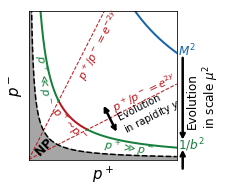

In [684]:

fig, ax = plt.subplots(1,1,figsize=(3.3,2.85))

d=0.3

x = np.linspace(-1, 6, 2000)
ax.fill_between(x, -.1*x/x, 0.7**2/np.max([x, 0.01*x/x], axis=0), color='k', alpha=0.35)


x = np.linspace(1e-3, 6, 2000)
ax.plot(x, np.tan(np.pi/2*d)*x, '--', color=cr2, lw=1)
ax.plot(x, np.tan(np.pi/2*(1-d))*x, '--', color=cr2, lw=1)

C2 = 2
cut = (np.tan(np.pi/2*d)*x<C2/x) & (C2/x< np.tan(np.pi/2*(1-d))*x)
ax.plot(x[cut], C2/x[cut],'-', color=cr2, lw=2)

cut = (np.tan(np.pi/2*d)*x>C2/x)
ax.plot(x[cut], C2/x[cut], '-', color=cg2, lw=2)

cut = (C2/x> np.tan(np.pi/2*(1-d))*x)
ax.plot(x[cut], C2/x[cut], '-', color=cg2, lw=2)

ax.plot(x, 18/x, '-', color=cb2, lw=2)

ax.plot(x, 0.7**2/x, 'k--')

ax.annotate(r"$\mathbf{NP}$", xy=(.025,.025), 
            xycoords='axes fraction', fontsize=12, rotation=45)

ax.set_xticks([])
ax.set_yticks([])


ax.annotate("$M^2$", color=cb2, xy=(1.01,.7), rotation=0,
            fontsize=12, xycoords='axes fraction')
ax.annotate(r"$1/b^2$", color=cg2, xy=(1.01,.07), rotation=0,
            fontsize=12, xycoords='axes fraction')
ax.annotate(r"$p^+/p^-=e^{2y}$", color=cr2, xy=(.55, .33), fontsize=11, 
            xycoords='axes fraction', rotation=27)
ax.annotate(r"$p^+/p^-=e^{-2y}$", color=cr2, xy=(.31, .55), fontsize=11, 
            xycoords='axes fraction', rotation=90-27)

ax.annotate(r"$p^+\gg p^-$", color=cg2, xy=(.5, .035), fontsize=11, xycoords='axes fraction', rotation=-7.5)
ax.annotate(r"$p^+\ll p^-$", color=cg2, xy=(.025, .4), fontsize=11, xycoords='axes fraction', rotation=-82.5)
ax.annotate("$p^+$~$p^-$", color=cr2, xy=(.13,.13), fontsize=11, xycoords='axes fraction', rotation=-45)

ax.annotate(s='', xy=(1.04, 0.7), xytext=(1.04,0.12), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='<-', lw=2.5))

ax.annotate(s='', xy=(.5, 0.4-.025), xytext=(.6,.2-.025), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='<->', lw=2.5))

ax.annotate(s='', xy=(1.04, 0.08), xytext=(1.04,-.075), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='->', lw=2.5))


ax.annotate("Evolution\nin scale $\mu^2$", xy=(1.06, 0.25), 
           rotation=90, fontsize=12, xycoords='axes fraction')
ax.annotate("Evolution \nin rapidity $y$", xy=(.59,.186), 
           rotation=27, fontsize=10, xycoords='axes fraction')


ax.set_xlim(0.,5)
ax.set_ylim(0,5)
ax.set_xlabel(r"$p^+$", fontsize=15)
ax.set_ylabel(r"$p^-$", fontsize=15)
plt.tight_layout()
ax.set_aspect('equal')

plt.savefig("Modes-vac.png", dpi=400, transparent=True)

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor rele

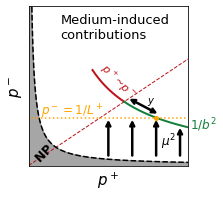

In [797]:

fig, ax = plt.subplots(1,1,figsize=(3.3,2.85))

d=0.375

x = np.linspace(-1, 6, 2000)
ax.fill_between(x, -.1*x/x, 0.7**2/np.max([x, 0.01*x/x], axis=0), color='k', alpha=0.35)


x = np.linspace(1e-3, 6, 2000)
ax.plot(x, np.tan(np.pi/2*d)*x, '--', color=cr2, lw=1)
#ax.plot(x, np.tan(np.pi/2*(1-d))*x, '--', color=cr2, lw=1)

C2 = 6
cut = (np.tan(np.pi/2*d)*x<C2/x) & (C2/x< np.tan(np.pi/2*(1-d))*x)
ax.plot(x[cut], C2/x[cut],'-', color=cr2, lw=2)

cut = (np.tan(np.pi/2*d)*x>C2/x)
ax.plot(x[cut], C2/x[cut], '-', color=cg2, lw=2)

#cut = (C2/x> np.tan(np.pi/2*(1-d))*x)
#ax.plot(x[cut], C2/x[cut], '-', color=cg2, lw=2)

#ax.plot(x, 18/x, '-', color=cb2, lw=2)

ax.plot(x, 0.7**2/x, 'k--')

ax.annotate(r"$\mathbf{NP}$", xy=(.025,.025), 
            xycoords='axes fraction', fontsize=12, rotation=45)

ax.set_xticks([])
ax.set_yticks([])


#ax.annotate("$M^2$", color=cb2, xy=(1.01,.7), rotation=0,
#            fontsize=12, xycoords='axes fraction')
ax.annotate(r"$1/b^2$", color=cg2, xy=(1.01,.23), rotation=0,
            fontsize=12, xycoords='axes fraction')
#ax.annotate(r"$p^+/p^-=e^{2y}$", color=cr2, xy=(.55, .33), fontsize=11, 
#            xycoords='axes fraction', rotation=27)
#ax.annotate(r"$p^+/p^-=e^{-2y}$", color=cr2, xy=(.31, .55), fontsize=11, 
#            xycoords='axes fraction', rotation=90-27)

#ax.annotate(r"$p^+\gg p^-$", color=cg2, xy=(.7, .3), fontsize=11, xycoords='axes fraction', rotation=-7.5)
#ax.annotate(r"$p^+\ll p^-$", color=cg2, xy=(.025, .4), fontsize=11, xycoords='axes fraction', rotation=-82.5)
ax.annotate("$p^+$~$p^-$", color=cr2, xy=(.43,.43), fontsize=11, xycoords='axes fraction', rotation=-45)

#ax.annotate(s='', xy=(1.04, 0.7), xytext=(1.04,0.12), xycoords='axes fraction',
#           arrowprops=dict(arrowstyle='<-', lw=2.5))

ax.annotate(s='', xy=(.42+.2, 0.25+.175), 
            xytext=(.62+.2,.2+.12), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='<->', lw=2.5))

ax.annotate(s='', xy=(.5,0.3), 
            xytext=(.5,.05), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='->', lw=2.5))
ax.annotate(s='', xy=(.65,0.3), 
            xytext=(.65,.05), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='->', lw=2.5))

ax.annotate(s='', xy=(.8,0.3), 
            xytext=(.8,.05), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='->', lw=2.5))

ax.annotate(s='', xy=(.95,0.25), 
            xytext=(.95,.05), xycoords='axes fraction',
           arrowprops=dict(arrowstyle='->', lw=2.5))

ax.plot([0,6],[1.5,1.5],':', color='orange')
ax.plot(4,1.5, 'o', ms=4, color='orange')
ax.annotate("$\mu^2$", xy=(.83, 0.125), 
           rotation=0, fontsize=12, xycoords='axes fraction')
ax.annotate("$y$", xy=(.745,.39), 
           rotation=0, fontsize=10, xycoords='axes fraction')

ax.annotate(r"$p^-=1/L^+$", xy=(.4, 1.6), 
            color='orange', rotation=0, fontsize=12)
ax.set_xlim(0.,5)
ax.set_ylim(0,5)
ax.set_xlabel(r"$p^+$", fontsize=15)
ax.set_ylabel(r"$p^-$", fontsize=15)
plt.tight_layout()
ax.set_aspect('equal')
ax.annotate("Medium-induced\ncontributions", xy=(1,4), fontsize=13)

plt.savefig("Modes-med.png", dpi=400, transparent=True)